# **Deep Learning Model for SEM Image Classification**

This notebook presents a deep learning pipeline for classifying Scanning Electron Microscopy (SEM) images into different categories: biological, fibres, film coated surfaces, MEMS, nanowires, particles, patterned surfaces, porous sponge, powder and tips. The approach utilizes a pre-trained InceptionV3 model, fine-tuning it on the specific SEM dataset for improved performance. 

**Data for the training come from https://b2share.eudat.eu/records/19cc2afd23e34b92b36a1dfd0113a89f**

<span style="font-size: 0.6em;">Aversa, R., Modarres, M. H., Cozzini, S., &amp; Ciancio, R. (2018). NFFA-EUROPE - SEM Dataset [Data set]. In Dataset of 18: Vol. 577 SEM images produced at CNR-IOM (Trieste (Version 1.0, pp. being the single images entirely detached from any specific information or scientific detail related to the displayed subject. This work has been done within the NFFA-EUROPE project (www.nffa.eu) and has received funding from the European Union’s Horizon 2020 Research and Innovation Programme under grant agreement No. 654360 NFFA). NFFA-EUROPE Project. https://doi.org/10.23728/B2SHARE.19CC2AFD23E34B92B36A1DFD0113A89F</span>

Below is a summary of the key steps and techniques used in the pipeline:

### **Overview of the Code Workflow**

1. **Dataset Preprocessing**: 
   - The SEM images are preprocessed by resizing them and organizing them into a structured dataset. The labels of the images are also encoded into numeric format for machine learning tasks.
   
2. **Data Augmentation**: 
   - To address the class imbalance in the dataset, several techniques are used:
     - **Undersampling**: The majority class is downsampled to balance the dataset.
     - **Oversampling (SMOTE)**: Synthetic Minority Over-sampling Technique (SMOTE) is applied to generate new samples for the minority class.
   
3. **Model Architecture**:
   - A **pre-trained InceptionV3 model** is used as the base model, leveraging its pre-learned features from ImageNet. The model is fine-tuned by unfreezing certain layers and training them on the SEM dataset. 
   - The top layers of the InceptionV3 model are replaced with a fully connected network, including a **Global Average Pooling layer** and **Dense layers** with dropout to reduce overfitting.

4. **Training the Model**:
   - The model is trained using the **Adam optimizer** and **categorical cross-entropy loss**. Several callbacks are used to monitor the training process:
     - **EarlyStopping**: Stops training if the validation loss doesn't improve.
     - **ModelCheckpoint**: Saves the best performing model based on validation loss.
     - **TensorBoard**: Logs the training process for visualization in TensorBoard.
   
5. **Fine-Tuning**:
   - After the initial training, some of the layers in the pre-trained base model are unfrozen to allow further adjustment during the fine-tuning phase. A lower learning rate (`1e-5`) is used to prevent large updates to the weights.

6. **Evaluation**:
   - After fine-tuning, the model is evaluated on a test set to assess its generalization performance. The test accuracy and loss are reported.

7. **Visualization**:
   - Training and validation loss, as well as accuracy curves, are plotted to monitor the model’s performance over epochs.

### **Techniques Utilized**
- **Transfer Learning**: Using a pre-trained model (InceptionV3) as the base, which significantly speeds up training and helps the model generalize better by leveraging features learned from large datasets like ImageNet.
- **Undersampling and Oversampling**: Addressing class imbalance through undersampling of the majority class and SMOTE for oversampling the minority class.
- **Fine-Tuning**: Unfreezing part of the pre-trained model to adjust its weights and optimize it for the specific SEM image classification task.
- **Callbacks for Training Monitoring**: Use of callbacks such as early stopping, model checkpoints, and TensorBoard for efficient training monitoring.

This code pipeline demonstrates a robust approach to SEM image classification using deep learning, ensuring the model learns effectively even with limited data and imbalanced classes.


This part of the code modifies the system path to include a custom directory where additional Python modules are stored.

In [1]:
import sys
sys.path.append(r'C:\Users\enryt\Documents\Python\SEM_Deeplearning\semlib')


In [2]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import logging
import datetime
import seaborn as sns
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import dataset_preprocessing
import dataset_cleaning


### **Path Setup and Logging Configuration**
This section sets up essential paths for the dataset, logging, and output directories, ensuring organized file management and proper logging.

#### **Dataset and Metadata Paths**
- `dataset_path`: Path to the main dataset directory containing SEM images.
- `csv_path`: Path to the CSV file storing metadata (e.g., labels, descriptions) for the SEM images.

#### **Dynamic Directory Naming**
To keep outputs well-organized, directories are dynamically created based on the current timestamp:
- `now`: Generates a timestamp (`YYYY.MM.DD-HHMMSS`) to create unique working directories for each execution.
- `base_path`: Defines the main working directory for this run.
- `cropped_dataset_path`: Stores cropped SEM images.
- `log_path`: Directory for logs.
- `failed_path`: Directory for images that failed processing.

#### **Logging Setup**
A logging system is configured to track unprocessed images:
- `log_file_path`: Specifies the log file (`unprocessed_images.log`).
- `os.makedirs(os.path.dirname(log_file_path), exist_ok=True)`: Ensures the log directory is created if it doesn’t already exist.
- `logging.basicConfig(...)`: Configures logging:
  - Logs are saved to `unprocessed_images.log`.
  - The logging level is set to `INFO`.
  - Each log entry includes a timestamp in `DD/MM/YYYY HH:MM:SS` format.

This setup ensures structured file management and efficient debugging.


In [3]:

dataset_path = r'C:\Users\enryt\Documents\Python\SEM_Deeplearning\dataset'
csv_path = r'C:\Users\enryt\Documents\Python\SEM_Deeplearning\sem_images_metadata.csv'

now = datetime.datetime.now().strftime("%Y.%m.%d-%H%M%S")
base_path = os.path.join(r'C:\Users\enryt\Documents\Python\SEM_Deeplearning', "working", now)
cropped_dataset_path = os.path.join(base_path, 'crop', 'images')
log_path = os.path.join(base_path, 'logs')
failed_path = os.path.join(base_path, 'failed', 'images')

log_file_path = os.path.join(log_path, 'unprocessed_images.log')
os.makedirs(os.path.dirname(log_file_path), exist_ok=True)
logging.basicConfig(
    filename=log_file_path,
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%d/%m/%Y %H:%M:%S'
)

### **Loading and Processing Dataset Metadata**
This section ensures that the metadata CSV file exists, loads it into a DataFrame, assigns numerical labels, and visualizes the class distribution.

#### **Checking and Creating Metadata CSV**
- If the metadata CSV file (`sem_images_metadata.csv`) does not exist, it is created using `dataset_preprocessing.create_csv(csv_path, dataset_path)`.
- The CSV file is then loaded into a Pandas DataFrame (`metadata_df`).

#### **Assigning Numerical Labels**
- The column `label_id` is created by converting categorical labels into numerical codes using `pd.Categorical(metadata_df['label']).codes`.

#### **Displaying Metadata Information**
- `metadata_df.info()`: Prints DataFrame structure, showing column names, data types, and non-null values.
- `metadata_df['label'].value_counts()`: Displays the distribution of textual labels (class names).
- `metadata_df['label_id'].value_counts()`: Displays the distribution of numerical labels.

#### **Visualizing Class Imbalance**
- A bar chart is generated to show the distribution of different SEM image categories.
- The chart is titled **"Dataset Sbilanciato"** (Unbalanced Dataset), highlighting any class imbalance in the dataset.

This setup helps understand the dataset composition before training the deep learning model.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21100 entries, 0 to 21099
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  21100 non-null  object
 1   label     21100 non-null  object
 2   path      21100 non-null  object
 3   label_id  21100 non-null  int8  
dtypes: int8(1), object(3)
memory usage: 515.3+ KB
None
Distribuzione delle etichette (testuali):
label
Patterned_surface              4752
MEMS_devices_and_electrodes    4583
Particles                      3905
Nanowires                      3815
Tips                           1561
Biological                      953
Powder                          898
Films_Coated_Surface            309
Porous_Sponge                   174
Fibres                          150
Name: count, dtype: int64
Distribuzione delle etichette (numeriche):
label_id
6    4752
3    4583
5    3905
4    3815
9    1561
0     953
8     898
2     309
7     174
1     150
Name: count, dtype: in

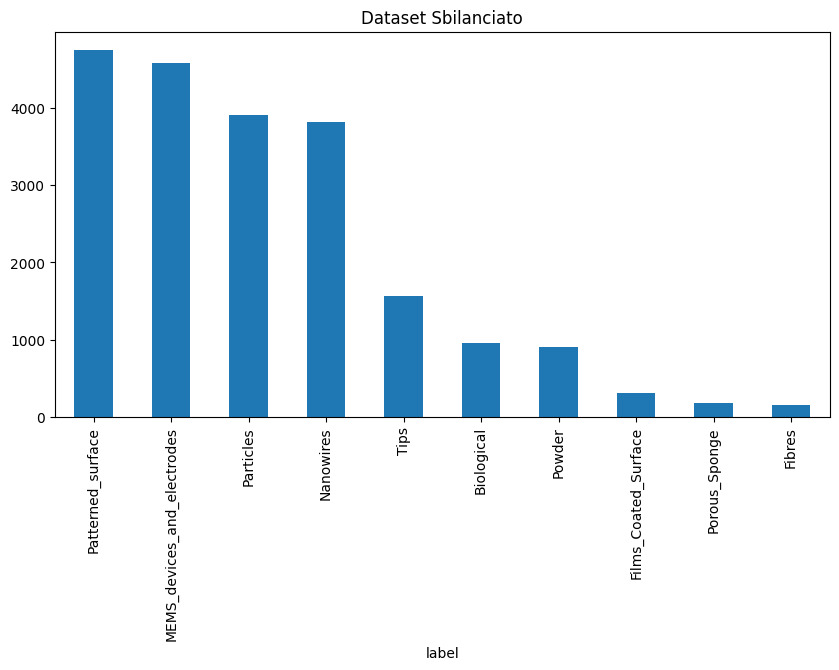

In [4]:

if not os.path.exists(csv_path):
    dataset_preprocessing.create_csv(csv_path, dataset_path)

metadata_df = pd.read_csv(csv_path)

metadata_df['label_id'] = pd.Categorical(metadata_df['label']).codes

print(metadata_df.info())
print("Distribuzione delle etichette (testuali):")
print(metadata_df['label'].value_counts())
print("Distribuzione delle etichette (numeriche):")
print(metadata_df['label_id'].value_counts())

plt.figure(figsize=(10, 5))
plt.title('Dataset Sbilanciato')
metadata_df['label'].value_counts().plot(kind='bar')
plt.show()


### **Sampling a Subset of the Dataset**
To reduce computational load and speed up experimentation, a random subset of the dataset is selected.

#### **Random Sampling**
- `metadata_df.sample(frac=0.2, random_state=1).copy()`:  
  - Selects **20%** of the dataset while maintaining the original distribution.
  - `random_state=1` ensures reproducibility.
  - `.copy()` creates an independent copy to avoid modifying the original DataFrame.

#### **Visualizing the Sampled Dataset**
- A bar chart is generated to visualize the label distribution in the reduced dataset.
- The title **"Dataset Ridotto (Campionamento)"** means **"Reduced Dataset (Sampling)"**, indicating that only a fraction of the original dataset is used.

This step helps manage large datasets efficiently while preserving the overall class distribution.


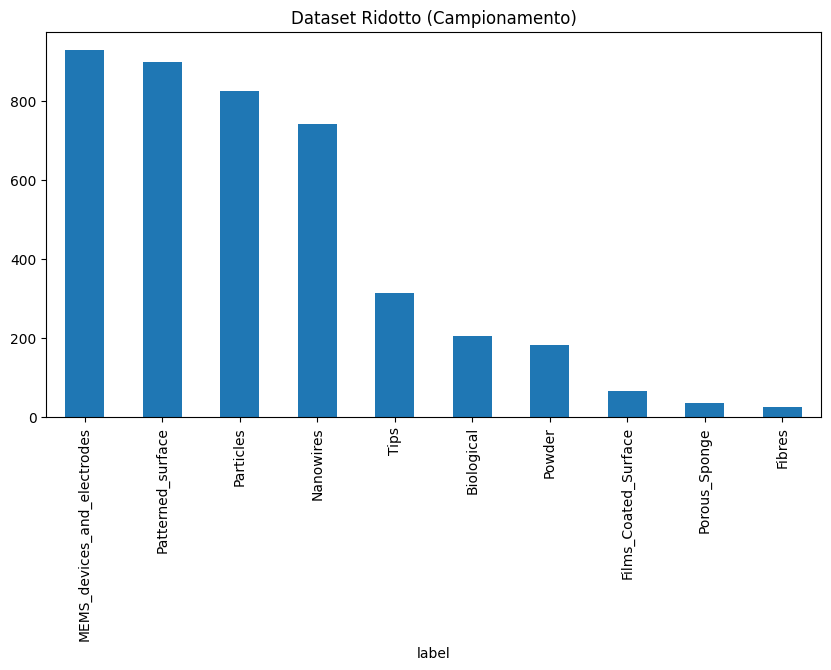

In [5]:

metadata_df = metadata_df.sample(frac=0.2, random_state=1).copy()

plt.figure(figsize=(10, 5))
plt.title('Dataset Ridotto (Campionamento)')
metadata_df['label'].value_counts().plot(kind='bar')
plt.show()


### **Preprocessing Images and Updating Metadata**
This section prepares SEM images for deep learning by resizing them to a fixed size and updating the dataset.

#### **Setting Image Size**
- `image_size = (299, 299)`:  
  - Defines a fixed resolution for input images.
  - Ensures consistency for deep learning model training.

#### **Applying Image Preprocessing**
- `dataset_preprocessing.set_images(metadata_df, image_size)`:  
  - Processes and resizes images based on the specified `image_size`.
  - Updates `metadata_df` to reflect the changes.

#### **Previewing the Updated DataFrame**
- Prints the first few rows of `metadata_df` to verify that images have been successfully processed.
- The title **"Anteprima del DataFrame con le immagini preprocessate"** translates to **"Preview of the DataFrame with Preprocessed Images"**.

This step ensures that all images are properly formatted before being fed into the deep learning model.


In [6]:
image_size = (299, 299)

dataset_preprocessing.set_images(metadata_df, image_size)

print("Anteprima del DataFrame con le immagini preprocessate:")
print(metadata_df.head())


Anteprima del DataFrame con le immagini preprocessate:
                                      filename                        label  \
717    L7_c06bc1890285861c6b549de4b986f936.jpg                   Biological   
10517  L2_2da7d41d587658750ef098d9d396cc29.jpg                    Particles   
19930  L5_4151403eed52d0061f872338d5b80a9f.jpg                         Tips   
11571  L2_7390a679361f036ec27818e6b389e4a8.jpg                    Particles   
2230   L8_2c20e38e1df068e46dda6ab82e07db68.jpg  MEMS_devices_and_electrodes   

                                                    path  label_id  \
717    C:\Users\enryt\Documents\Python\SEM_Deeplearni...         0   
10517  C:\Users\enryt\Documents\Python\SEM_Deeplearni...         5   
19930  C:\Users\enryt\Documents\Python\SEM_Deeplearni...         9   
11571  C:\Users\enryt\Documents\Python\SEM_Deeplearni...         5   
2230   C:\Users\enryt\Documents\Python\SEM_Deeplearni...         3   

                                              ima

### **Visualizing Sample SEM Images by Defect Type**
This section generates a grid of sample images for each defect category to better understand the dataset.

#### **Defining Visualization Parameters**
- `count_types_of_defects = len(metadata_df['label'].unique())`:  
  - Counts the number of unique defect types.
- `n_samples = 6`:  
  - Specifies the number of images to display per defect type.
- `figsize_m = (n_samples / 2)`:  
  - Determines the figure size dynamically based on the number of samples.

#### **Creating a Grid of Sample Images**
- `plt.subplots(...)`:  
  - Creates a grid where each row corresponds to a defect type, and each column contains a sample image.
- `metadata_df.sort_values(['label']).groupby('label')`:  
  - Groups the dataset by defect type and sorts it for better organization.
- `ax.imshow(row['image_data'])`:  
  - Displays each image using the preprocessed data.
- `ax.axis('off')`:  
  - Hides axis labels for a cleaner visualization.

#### **Saving the Figure**
- `fig.savefig(figures_path, dpi=300)`:  
  - Saves the image grid to a file for future reference.
- `os.makedirs(os.path.dirname(figures_path), exist_ok=True)`:  
  - Ensures that the target directory exists before saving.

#### **Displaying the Images**
- `plt.show()`:  
  - Renders the grid of images within the notebook.

This step helps visually inspect the dataset and confirm image quality before training the deep learning model.


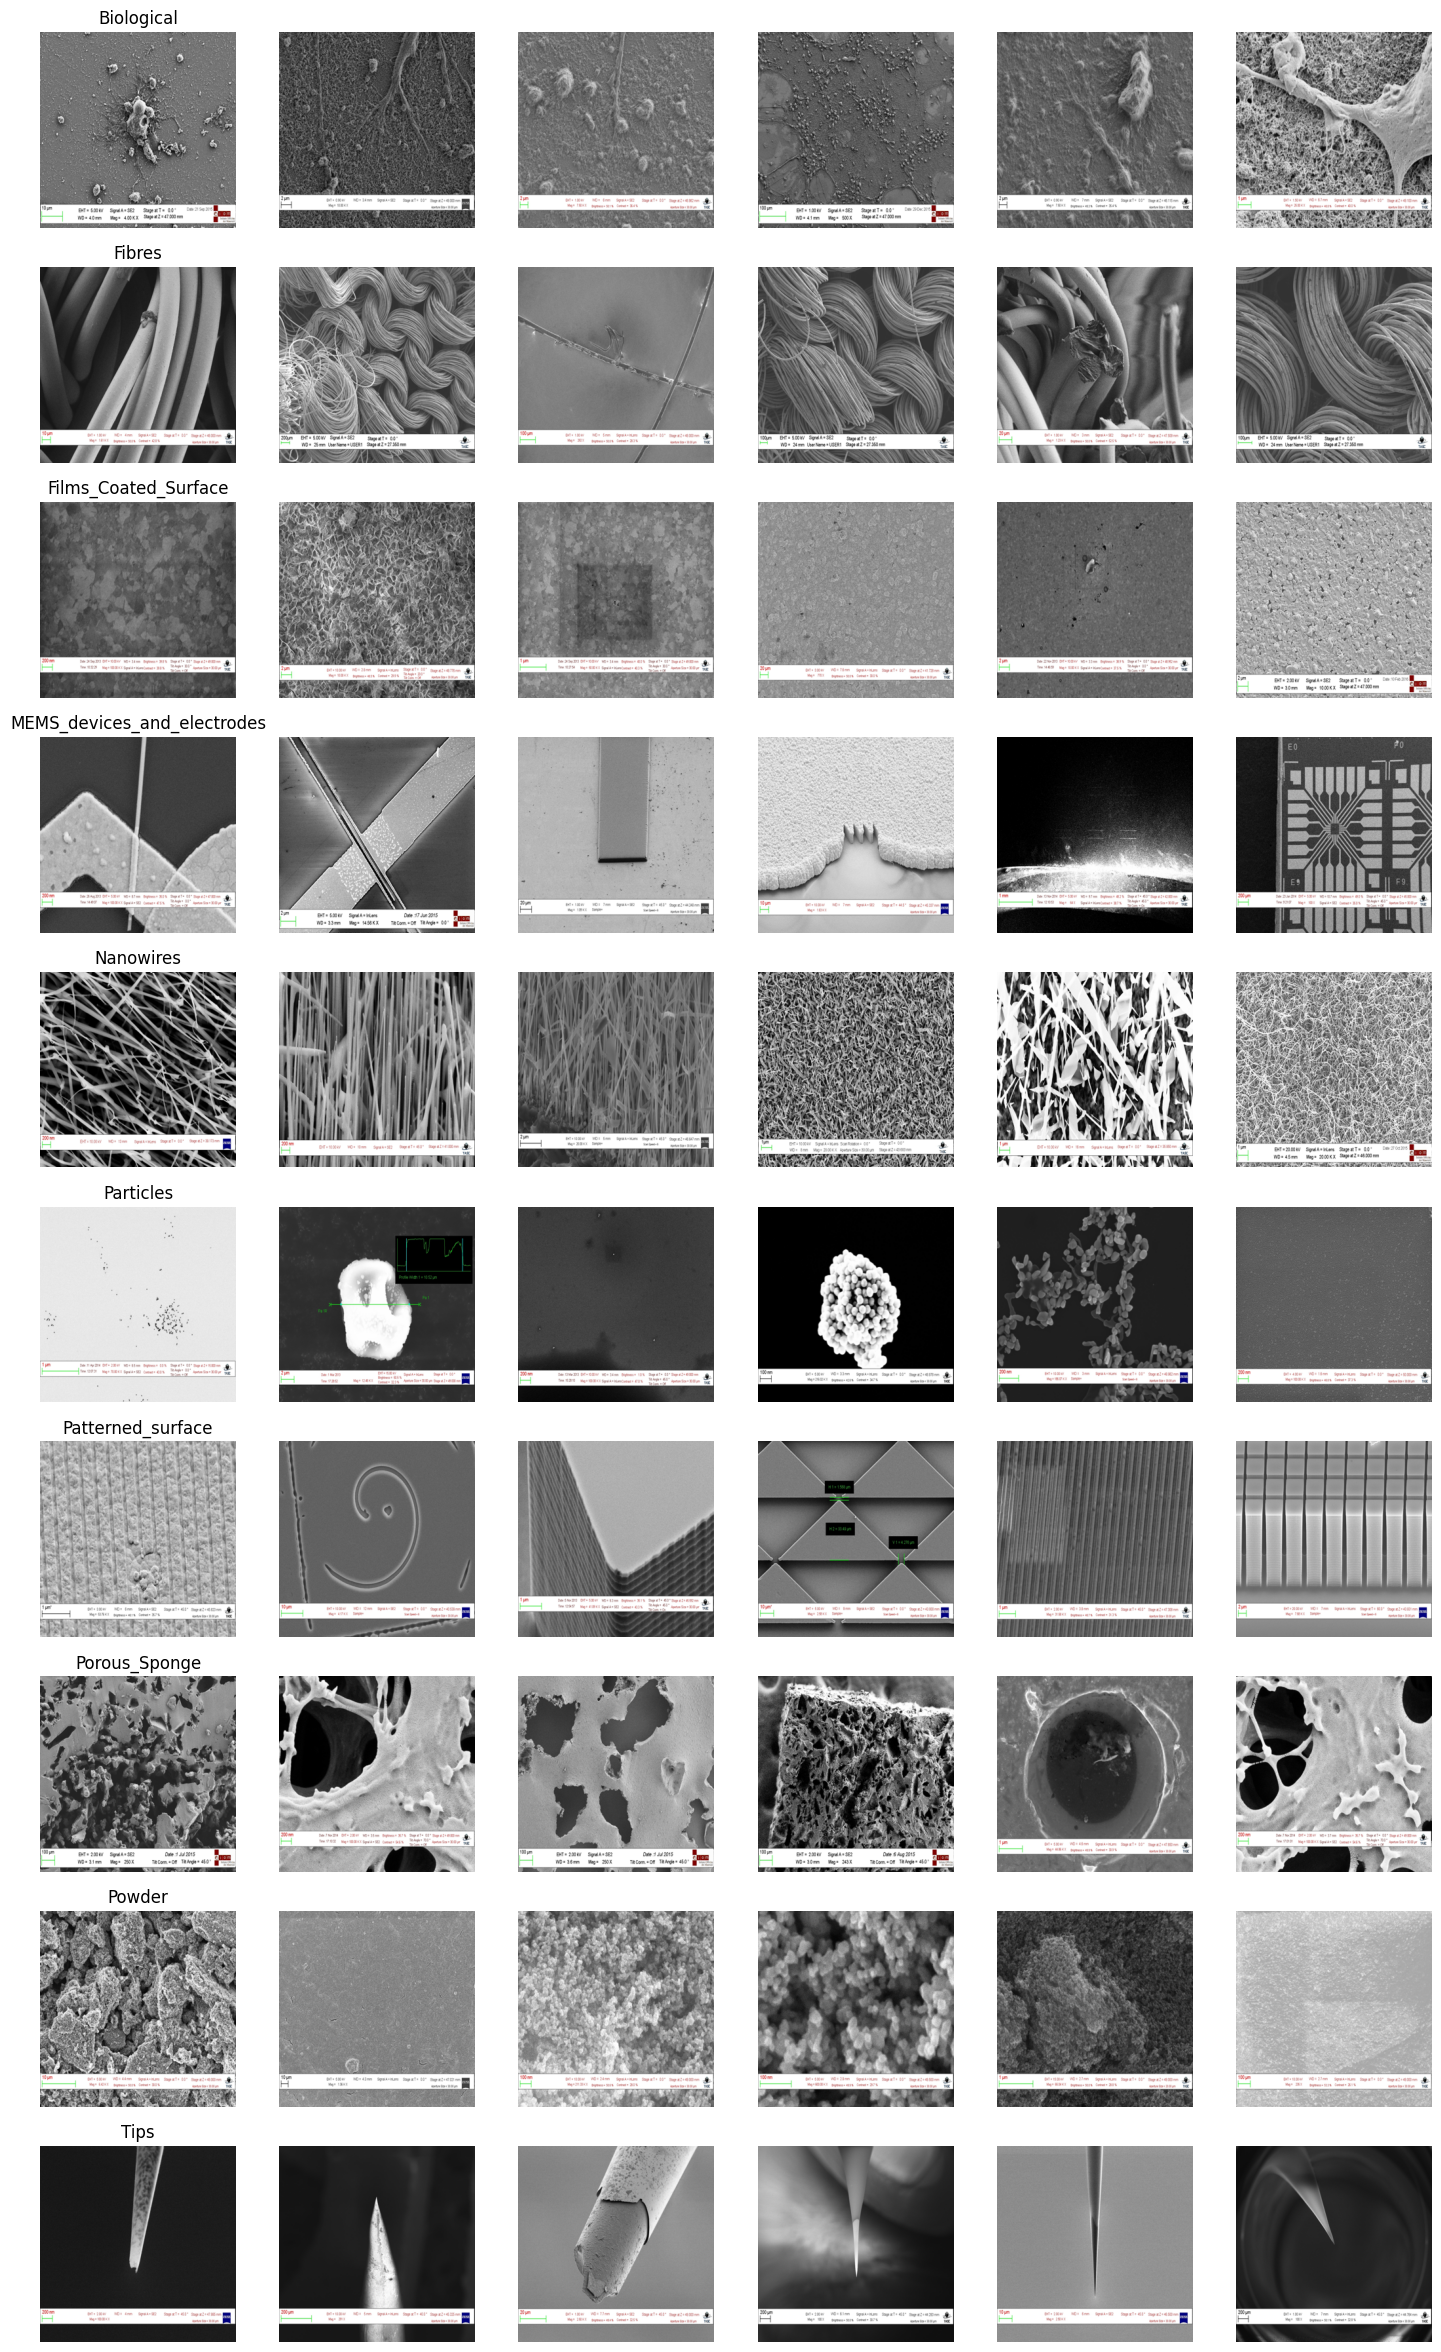

In [7]:
count_types_of_defects = len(metadata_df['label'].unique())
n_samples = 6

figsize_m = (n_samples / 2)

fig, defect_sample_axs = plt.subplots(nrows=count_types_of_defects,
                                      ncols=n_samples,
                                      figsize=(figsize_m * n_samples,
                                               figsize_m * count_types_of_defects))

for ax_row, (defect_name, defect_rows) in zip(defect_sample_axs,
                                               metadata_df.sort_values(['label']).groupby('label')):
    ax_row[0].set_title(defect_name)
    
    for ax, (_, row) in zip(ax_row, defect_rows.sample(n_samples, random_state=2021).iterrows()):
        ax.imshow(row['image_data'])
        ax.axis('off')

figures_path = os.path.join(base_path, 'figures', 'sme_samples-' + 'x'.join(map(str, image_size)) + '.jpg')
os.makedirs(os.path.dirname(figures_path), exist_ok=True)
fig.savefig(figures_path, dpi=300)
plt.show()


### **Splitting the Dataset into Train, Validation, and Test Sets**
This section splits the dataset into training, validation, and test sets, ensuring a balanced distribution of classes.

#### **Defining Split Ratios**
- `train_ratio = 0.6`: 60% of the dataset is allocated for training.
- `validation_ratio = 0.2`: 20% is reserved for validation.
- `test_ratio = 0.2`: The remaining 20% is used for testing.

#### **Preparing Features and Labels**
- `X = metadata_df`: Uses the full dataset as input features.
- `y = metadata_df['label_id']`: Defines labels as the numerical class identifiers.

#### **Splitting into Training and Remaining Data**
- `train_test_split(...)`:
  - `train_size=train_ratio`: Allocates 60% of the data to training.
  - `stratify=y`: Ensures an even distribution of labels across splits.
  - The remaining 40% of the data (`X_remain`, `y_remain`) will be further divided into validation and test sets.

#### **Computing the Adjusted Test Split Ratio**
- `new_test_ratio = np.around(test_ratio / (validation_ratio + test_ratio), 2)`:  
  - Adjusts the test split to maintain the correct proportions within the remaining 40% of the dataset.

#### **Splitting Remaining Data into Validation and Test Sets**
- `train_test_split(...)`:
  - `test_size=new_test_ratio`: Ensures the correct balance between validation and test sets.
  - `stratify=y_remain`: Maintains class balance in both validation and test splits.

#### **Displaying the Dataset Sizes**
- Prints the number of samples in the training, validation, and test sets to verify the split.

This step ensures the dataset is properly partitioned for effective deep learning model training and evaluation.


In [8]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X = metadata_df
y = metadata_df['label_id']

X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, train_size=train_ratio, random_state=1, stratify=y
)

new_test_ratio = np.around(test_ratio / (validation_ratio + test_ratio), 2)

X_test, X_val, y_test, y_val = train_test_split(
    X_remain, y_remain, test_size=new_test_ratio, random_state=0, stratify=y_remain
)

print("Train Data Size:", len(X_train))
print("Validation Data Size:", len(X_val))
print("Test Data Size:", len(X_test))

Train Data Size: 2532
Validation Data Size: 844
Test Data Size: 844


### **Handling Class Imbalance through Undersampling**
This section addresses class imbalance in the training dataset by undersampling the majority classes.

#### **Class Count and Undersampling Setup**
- `class_count = X_train['label_id'].value_counts()`:  
  - Calculates the number of samples in each class of the training dataset.
- `REDUCTION_FACTOR = 2`:  
  - Defines the reduction factor to limit the maximum class size.
- `class_limit = math.ceil(max(class_count) / REDUCTION_FACTOR)`:  
  - Calculates the new class limit by dividing the maximum class size by the reduction factor and rounding up.

#### **Applying Undersampling**
- `under_class_count = class_count.map(lambda x: class_limit if x > class_limit else x)`:  
  - Adjusts the number of samples per class. If a class exceeds the `class_limit`, it is reduced to the `class_limit`.
- `undersample = RandomUnderSampler(sampling_strategy=under_class_count.to_dict(), random_state=1)`:  
  - Configures the `RandomUnderSampler` from `imblearn` to balance the classes by undersampling.

#### **Reshaping Data for Training**
- `x_train_array = np.asarray(X_train['image_data'].tolist())`:  
  - Converts the image data into a NumPy array.
- `X_train_flat = x_train_array.reshape(len(x_train_array), -1)`:  
  - Flattens each image into a one-dimensional vector to apply undersampling.

#### **Resampling the Training Data**
- `X_under, y_under = undersample.fit_resample(X_train_flat, y_train_list)`:  
  - Applies undersampling to balance the dataset.
- `X_under = X_under.reshape(-1, image_size[0], image_size[1], 3)`:  
  - Reshapes the undersampled data back into image format (height, width, channels).

#### **Visualizing the Undersampled Dataset**
- A bar chart is generated to visualize the distribution of labels after undersampling, ensuring balanced class distribution.
- The title **"Undersampled Training Dataset"** indicates that the dataset has been adjusted for better class balance.

This step helps ensure the deep learning model is not biased toward overrepresented classes.


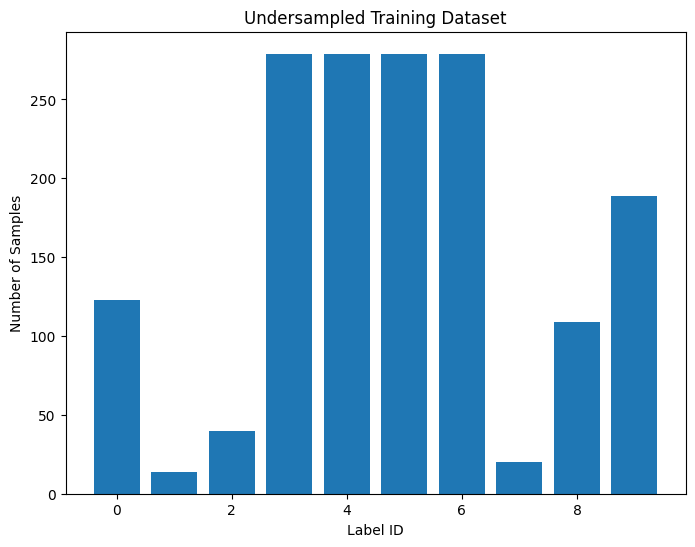

In [9]:
import math
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

class_count = X_train['label_id'].value_counts()

REDUCTION_FACTOR = 2
class_limit = math.ceil(max(class_count) / REDUCTION_FACTOR)

under_class_count = class_count.map(lambda x: class_limit if x > class_limit else x)

undersample = RandomUnderSampler(sampling_strategy=under_class_count.to_dict(), random_state=1)

x_train_array = np.asarray(X_train['image_data'].tolist())
y_train_list = y_train.tolist()

X_train_flat = x_train_array.reshape(len(x_train_array), -1)

X_under, y_under = undersample.fit_resample(X_train_flat, y_train_list)

X_under = X_under.reshape(-1, image_size[0], image_size[1], 3)

balanced_labels = Counter(y_under)
plt.figure(figsize=(8, 6))
plt.title('Undersampled Training Dataset')
plt.xlabel('Label ID')
plt.ylabel('Number of Samples')
plt.bar(list(balanced_labels.keys()), list(balanced_labels.values()), align='center')
plt.show()

### **Balancing the Dataset with Oversampling after Undersampling**
This section further balances the dataset by applying oversampling after undersampling, combining both techniques to handle class imbalance effectively.

#### **Reshaping the Undersampled Data**
- `X_under = X_under.reshape(len(X_under), -1)`:  
  - Flattens the undersampled images back into one-dimensional vectors to prepare for oversampling.

#### **Applying Oversampling with SMOTE**
- `oversample = SMOTE(random_state=1, k_neighbors=5)`:  
  - Initializes the **Synthetic Minority Over-sampling Technique (SMOTE)** to generate synthetic samples for the minority classes.
  - `k_neighbors=5`: Specifies that SMOTE will use the 5 nearest neighbors to generate synthetic samples.
- `X_over, y_over = oversample.fit_resample(X_under, y_under)`:  
  - Applies SMOTE to generate a balanced dataset with synthetic samples for underrepresented classes.

#### **Reshaping the Oversampled Data**
- `X_over = X_over.reshape(-1, 299, 299, 3)`:  
  - Reshapes the oversampled data back into the original image format (height, width, channels).

#### **Visualizing the Balanced Dataset**
- A bar chart is generated to display the class distribution after both undersampling and oversampling.
- The title **"Balanced dataset: Undersampling + Oversampling"** indicates that both techniques were applied to achieve a balanced dataset.
- `plt.xticks(...)`: Rotates the x-axis labels to improve readability.

#### **Updating Training Data**
- `X_train = X_over`: Updates the training data with the balanced dataset.
- `y_train = y_over`: Updates the training labels accordingly.

This step ensures the training dataset is well-balanced, improving the deep learning model's ability to generalize across all classes.


(2790, 268203)


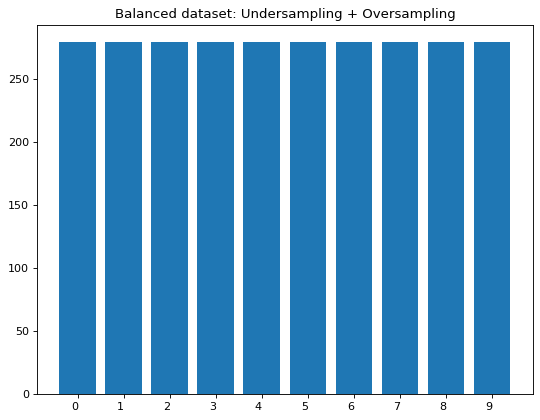

In [10]:
X_under = X_under.reshape(len(X_under), -1)

oversample = SMOTE(random_state=1, k_neighbors=5)
X_over, y_over = oversample.fit_resample(X_under, y_under)

print(X_over.shape)  

X_over = X_over.reshape(-1, 299, 299, 3)

balanced_labels = Counter(y_over)
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Balanced dataset: Undersampling + Oversampling')
plt.xticks(range(len(balanced_labels)), rotation=0, ha='right')
plt.bar(balanced_labels.keys(), balanced_labels.values(), align='center')
plt.show()

X_train = X_over
y_train = y_over

### **Data Augmentation and Iterator Setup**
This section prepares data augmentation and creates iterators for the training, validation, and test datasets, enabling efficient batching during model training.

#### **Image Rescaling with `ImageDataGenerator`**
- `datagen = ImageDataGenerator(rescale=1.0/255.0)`:  
  - Creates an `ImageDataGenerator` instance for data augmentation.
  - The `rescale=1.0/255.0` parameter normalizes pixel values to the range [0, 1] by dividing by 255.

#### **Batch Size Definition**
- `BATCH_SIZE = 32`:  
  - Defines the batch size used during training and validation. A batch size of 32 is commonly used, balancing memory usage and training speed.

#### **Creating Data Iterators**
- `train_iterator = datagen.flow(...)`:  
  - Creates a data iterator for the training set:
    - `x=X_train`: Uses the training images.
    - `y=to_categorical(y_train, num_classes=count_types_of_defects)`: Converts the labels into one-hot encoded vectors for categorical classification.
    - `batch_size=BATCH_SIZE`: Defines the number of samples per batch.
  
- `validation_iterator = datagen.flow(...)`:  
  - Creates a data iterator for the validation set:
    - `x=np.asarray(X_val['image_data'].tolist())`: Converts the validation images into a NumPy array.
    - `y=to_categorical(y_val, num_classes=count_types_of_defects)`: One-hot encodes the validation labels.
    - `batch_size=BATCH_SIZE`: Specifies the batch size for validation.

- `test_iterator = datagen.flow(...)`:  
  - Creates a data iterator for the test set:
    - `x=np.asarray(X_test['image_data'].tolist())`: Converts the test images into a NumPy array.
    - `y=to_categorical(y_test, num_classes=count_types_of_defects)`: One-hot encodes the test labels.
    - `batch_size=BATCH_SIZE`: Sets the batch size for testing.
    - `shuffle=False`: Disables shuffling of the test data (important for accurate evaluation).

This step ensures the data is efficiently loaded and preprocessed in batches, ready for model training, validation, and testing.


In [11]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)

BATCH_SIZE = 32

train_iterator = datagen.flow(
    x=X_train,
    y=to_categorical(y_train, num_classes=count_types_of_defects),
    batch_size=BATCH_SIZE,
)

validation_iterator = datagen.flow(
    x=np.asarray(X_val['image_data'].tolist()),
    y=to_categorical(y_val, num_classes=count_types_of_defects),
    batch_size=BATCH_SIZE,
)

test_iterator = datagen.flow(
    x=np.asarray(X_test['image_data'].tolist()),
    y=to_categorical(y_test, num_classes=count_types_of_defects),
    batch_size=BATCH_SIZE,
    shuffle=False
)


### **Logging and Checkpoint Paths Setup**
This section configures logging paths and checkpoint directories for model training, ensuring that the model’s progress and best weights are saved.

#### **Printing Number of Defect Types**
- `print(count_types_of_defects)`:  
  - Prints the number of unique defect types in the dataset.

#### **Setting Up Logging and Checkpoint Directories**
- `log_dir = os.path.join(log_path, 'sem18000')`:  
  - Defines the main directory for logging during training.
  
- `tb_log_dir = os.path.join(log_dir, 'tensorboard')`:  
  - Sets the directory for TensorBoard logs, allowing visualization of training metrics.

- `filename = 'top-model.{epoch:02d}-{val_loss:.2f}.h5'`:  
  - Defines the filename format for saving checkpoints of the top layers of the model, including the epoch number and validation loss.

- `top_layers_checkpoint_path = os.path.join(log_dir, 'checkpoints', 'top_model', filename)`:  
  - Defines the full path where top-layer model checkpoints will be stored.

- `filename = 'fine_tuned-model.{epoch:02d}-{val_loss:.2f}.h5'`:  
  - Defines the filename format for saving checkpoints of the fine-tuned model.

- `fine_tuned_layers_checkpoint_path = os.path.join(log_dir, 'checkpoints', 'fine_tuned_model', filename)`:  
  - Defines the full path for storing checkpoints of the fine-tuned model.

- `filename = 'fine_tuned-inception_weights.h5'`:  
  - Defines the filename for saving the weights of the fine-tuned Inception model.

- `fine_tuned_inception_weights = os.path.join(log_dir, 'checkpoints', filename)`:  
  - Defines the full path for saving the fine-tuned Inception model weights.

- `csv_logger_path = os.path.join(log_dir, 'training.log')`:  
  - Sets the path for logging training progress into a CSV file.

#### **Printing the Configured Paths**
- Prints the paths for:
  - **TensorBoard logs**: For visualizing training metrics.
  - **Top layers checkpoint**: For saving the top-layer model.
  - **Fine-tuned layers checkpoint**: For saving the fine-tuned model.
  - **CSV logger**: For storing training logs.

This setup ensures that important training information and model checkpoints are saved for monitoring and resuming training as needed.


In [12]:
print(count_types_of_defects)

log_dir = os.path.join(log_path, 'sem18000')
tb_log_dir = os.path.join(log_dir, 'tensorboard')

filename = 'top-model.{epoch:02d}-{val_loss:.2f}.h5'
top_layers_checkpoint_path = os.path.join(log_dir, 'checkpoints', 'top_model', filename)

filename = 'fine_tuned-model.{epoch:02d}-{val_loss:.2f}.h5'
fine_tuned_layers_checkpoint_path = os.path.join(log_dir, 'checkpoints', 'fine_tuned_model', filename)

filename = 'fine_tuned-inception_weights.h5'
fine_tuned_inception_weights = os.path.join(log_dir, 'checkpoints', filename)

csv_logger_path = os.path.join(log_dir, 'training.log')

print('TensorBoard path:', tb_log_dir)
print('Top layers checkpoint path:', top_layers_checkpoint_path)
print('Fine tuned layers checkpoint path:', fine_tuned_layers_checkpoint_path)
print('CSV logger path:', csv_logger_path)


10
TensorBoard path: C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\tensorboard
Top layers checkpoint path: C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\checkpoints\top_model\top-model.{epoch:02d}-{val_loss:.2f}.h5
Fine tuned layers checkpoint path: C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\checkpoints\fine_tuned_model\fine_tuned-model.{epoch:02d}-{val_loss:.2f}.h5
CSV logger path: C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\training.log


### **Callbacks Setup for Training**
This section configures several callbacks that will monitor the training process and take actions such as saving models, logging metrics, and stopping early if necessary.

#### **Early Stopping Callback**
- `es_callback = tf.keras.callbacks.EarlyStopping(...)`:  
  - Stops training early if the validation loss stops improving, preventing overfitting:
    - `monitor='val_loss'`: Monitors the validation loss.
    - `verbose=1`: Displays a message when early stopping is triggered.
    - `patience=80`: Stops training if no improvement is seen in the validation loss for 80 consecutive epochs.
    - `mode='min'`: Monitors the minimum value of `val_loss` (stopping if the validation loss doesn't improve).
    - `restore_best_weights=True`: Restores the best weights observed during training.

#### **TensorBoard Callback**
- `tb_callback = tf.keras.callbacks.TensorBoard(...)`:  
  - Logs training metrics for TensorBoard visualization:
    - `log_dir=tb_log_dir`: Specifies the directory where logs will be stored.
    - `histogram_freq=1`: Logs histograms of weights for every epoch.

#### **CSV Logger Callback**
- `csv_logger_callback = tf.keras.callbacks.CSVLogger(...)`:  
  - Logs training progress into a CSV file:
    - `csv_logger_path`: Specifies the path for saving the log file.
    - `separator=","`: Defines the separator between columns.
    - `append=False`: Overwrites the file each time training starts.

#### **Model Checkpoint Callbacks**
- **Top Layers Model Checkpoint**:
  - `mc_top_callback = tf.keras.callbacks.ModelCheckpoint(...)`:  
    - Saves the best weights for the top layers of the model during training:
      - `filepath=top_layers_checkpoint_path`: Specifies the path to save the model checkpoints.
      - `verbose=1`: Displays messages when a checkpoint is saved.
      - `monitor='val_loss'`: Monitors the validation loss for saving the best model.
      - `mode='min'`: Saves the model when the validation loss reaches a minimum.
      - `save_freq='epoch'`: Saves the model at the end of every epoch.
      - `save_best_only=True`: Saves only the best model (with the lowest validation loss).
  
- **Fine-Tuned Model Checkpoint**:
  - `mc_fine_tuned_callback = tf.keras.callbacks.ModelCheckpoint(...)`:  
    - Saves the fine-tuned model checkpoints in a similar manner, ensuring that only the best model is saved during training.

This setup ensures that model training is well-logged, early stopping occurs when necessary, and checkpoints for both top layers and fine-tuned models are saved throughout the training process.


In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=80, 
    mode='min',
    restore_best_weights=True
)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1)

csv_logger_callback = tf.keras.callbacks.CSVLogger(csv_logger_path, separator=",", append=False)

mc_top_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=top_layers_checkpoint_path,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True
)

mc_fine_tuned_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fine_tuned_layers_checkpoint_path,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True
)



### **Model Architecture: InceptionV3 with Fine-Tuning**
This section sets up a deep learning model using the pre-trained **InceptionV3** model, followed by custom layers to adapt it to the specific task of classifying SEM images.

#### **Loading the Pre-Trained InceptionV3 Model**
- `base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))`:  
  - Loads the **InceptionV3** model pre-trained on ImageNet:
    - `weights='imagenet'`: Uses the pre-trained weights learned on the ImageNet dataset.
    - `include_top=False`: Excludes the fully connected layers at the top, allowing us to customize the output layer for our task.
    - `input_shape=(299, 299, 3)`: Specifies the input shape for the model (299x299 pixel images with 3 color channels).

#### **Freezing the Base Model**
- `base_model.trainable = False`:  
  - Freezes the weights of the pre-trained **InceptionV3** model, preventing them from being updated during training. This is done to leverage the pre-trained features and prevent overfitting, especially when working with smaller datasets.

#### **Custom Layers for Classification**
- `model = models.Sequential([ ... ])`:  
  - Creates a Sequential model and adds custom layers on top of the base **InceptionV3** model:
    1. **Global Average Pooling Layer**:  
       - `layers.GlobalAveragePooling2D()`: Reduces each feature map to a single value by averaging over all spatial locations.
    2. **Fully Connected (Dense) Layer**:  
       - `layers.Dense(1024, activation='relu')`: Adds a dense layer with 1024 neurons and ReLU activation to introduce non-linearity.
    3. **Dropout Layer**:  
       - `layers.Dropout(0.5)`: Adds a dropout layer with a 50% drop rate to prevent overfitting.
    4. **Output Layer**:  
       - `layers.Dense(count_types_of_defects, activation='softmax')`: Adds the final dense layer with the number of neurons equal to the number of defect types, using the **softmax** activation function to output probabilities for each class.

This model leverages a pre-trained InceptionV3 model as a feature extractor and fine-tunes it for the specific task of SEM image classification.


In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,  
    layers.GlobalAveragePooling2D(),  
    layers.Dense(1024, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(count_types_of_defects, activation='softmax')  
])


### **Model Summary and Compilation**
In this section, we inspect the model's architecture and then compile it for training.

#### **Displaying the Model Summary**
- `model.summary()`:  
  - Displays a summary of the model architecture, including the layers, the number of parameters in each layer, and the total number of trainable parameters. This helps verify that the model is set up correctly and gives insight into the complexity of the model.

#### **Compiling the Model**
- `model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])`:  
  - Compiles the model with the following settings:
    - **Optimizer**: `adam`
      - Adam is a popular optimizer that adapts the learning rate during training, helping the model converge faster and more efficiently.
    - **Loss Function**: `categorical_crossentropy`
      - Used for multi-class classification tasks. It computes the loss based on the difference between the true labels and the predicted probabilities.
    - **Metrics**: `accuracy`
      - Tracks the accuracy of the model during training and evaluation, which is important for classification tasks.

This prepares the model for training, ensuring it's optimized, the correct loss function is used, and metrics are set to monitor the model's performance.


In [15]:

model.summary()


model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
____________________________________

### **Model Training, Evaluation, and Saving**
This section handles the model's training, evaluates its performance on the test set, and saves the final model.

#### **Training the Model**
- `history = model.fit(...)`:  
  - Trains the model on the training data:
    - `train_iterator`: The training data iterator, feeding the model batches of images and labels.
    - `epochs=10`: Specifies that the model will train for 10 epochs.
    - `validation_data=validation_iterator`: Uses the validation set for monitoring the model’s performance after each epoch.
    - `callbacks=[...]`: Includes several callbacks to:
      - **EarlyStopping**: Stop training early if the validation loss stops improving.
      - **TensorBoard**: Log metrics for TensorBoard visualization.
      - **ModelCheckpoint (Top Layers)**: Save the best weights for the top layers.
      - **ModelCheckpoint (Fine-Tuned)**: Save the best weights for the fine-tuned model.
      - **CSVLogger**: Log training progress into a CSV file.
    - `verbose=1`: Displays training progress after each epoch.

#### **Evaluating the Model on the Test Set**
- `test_loss, test_acc = model.evaluate(test_iterator, verbose=2)`:  
  - Evaluates the model’s performance on the test set:
    - `test_iterator`: The test data iterator.
    - `verbose=2`: Displays detailed evaluation results.
  - Prints the test accuracy using:  
    `print(f'Test accuracy: {test_acc}')`

#### **Making Predictions on the Test Set**
- `predictions = model.predict(test_iterator)`:  
  - Generates predictions for the test set using the trained model.

#### **Saving the Final Model**
- `model.save(os.path.join(log_dir, 'final_model.h5'))`:  
  - Saves the final trained model to a file (`final_model.h5`) in the log directory. This allows for easy loading and inference in the future.

This section ensures that the model is trained, evaluated, and saved, allowing for future use or further analysis.


In [16]:
history = model.fit(
    train_iterator,  
    epochs=10,  
    validation_data=validation_iterator, 
    callbacks=[es_callback, tb_callback, mc_top_callback, mc_fine_tuned_callback, csv_logger_callback],
    verbose=1  
)


test_loss, test_acc = model.evaluate(test_iterator, verbose=2)
print(f'Test accuracy: {test_acc}')

predictions = model.predict(test_iterator)


model.save(os.path.join(log_dir, 'final_model.h5'))


Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 1.1983 - accuracy: 0.6247
Epoch 1: val_loss improved from inf to 0.78379, saving model to C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\checkpoints\top_model\top-model.01-0.78.h5

Epoch 1: val_loss improved from inf to 0.78379, saving model to C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\checkpoints\fine_tuned_model\fine_tuned-model.01-0.78.h5
88/88 [==============================] - 447s 5s/step - loss: 1.1983 - accuracy: 0.6247 - val_loss: 0.7838 - val_accuracy: 0.7168
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.8265
Epoch 2: val_loss improved from 0.78379 to 0.65035, saving model to C:\Users\enryt\Documents\Python\SEM_Deeplearning\working\2025.02.11-150103\logs\sem18000\checkpoints\top_model\top-model.02-0.65.h5

Epoch 2: val_loss improved from 0.78379 to 0.65035, saving model to C:\Use

### **Fine-Tuning the Model**

In this section, the model undergoes fine-tuning by unfreezing part of the pre-trained layers and training the model again on the dataset.

#### **Unfreezing Layers for Fine-Tuning**
- `for layer in base_model.layers[:290]: layer.trainable = False`:  
  - Freezes the first 290 layers of the **InceptionV3** base model to retain the pre-trained features. These layers will not be updated during fine-tuning.
  
- `for layer in base_model.layers[290:]: layer.trainable = True`:  
  - Unfreezes the remaining layers (from layer 290 onward) to allow fine-tuning, enabling the model to adapt to the SEM image classification task.

#### **Compiling the Model for Fine-Tuning**
- `model.compile(...)`:  
  - Compiles the model with the following settings for fine-tuning:
    - **Optimizer**: `Adam` with a learning rate of `1e-5` to allow gradual fine-tuning.
    - **Loss Function**: `categorical_crossentropy` for multi-class classification.
    - **Metrics**: `accuracy` to track classification performance.

#### **Training the Model**
- `history = model.fit(...)`:  
  - Fine-tunes the model by training it on the dataset with the newly unfrozen layers:
    - `train_iterator`: The training data iterator.
    - `validation_data=validation_iterator`: Validation data for monitoring performance.
    - `epochs=EPOCHS`: Specifies the number of epochs (10 in this case).
    - `shuffle=True`: Shuffles the training data after each epoch.
    - `callbacks=[...]`: Includes callbacks for saving the fine-tuned model (`mc_fine_tuned_callback`), TensorBoard logging (`tb_callback`), and CSV logging (`csv_logger_callback`).

#### **Plotting the Training and Validation Loss/Accuracy**
- `fig, ax = plt.subplots(2, 1, figsize=(9, 9))`:  
  - Creates a subplot with two graphs to visualize the loss and accuracy during fine-tuning:
    - **Training and Validation Loss**:
      - Plots the training loss (`history.history['loss']`) and validation loss (`history.history['val_loss']`).
    - **Training and Validation Accuracy**:
      - Plots the training accuracy (`history.history['accuracy']`) and validation accuracy (`history.history['val_accuracy']`).

#### **Saving the Fine-Tuned Model's Training Plot**
- `plt.savefig(figures_path, dpi=300)`:  
  - Saves the plot as a high-quality image showing the loss and accuracy for both training and validation sets during fine-tuning.

This part of the process allows the model to adjust its weights in the unfrozen layers to improve performance, followed by visualizing the training progress.


Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9176
Epoch 1: val_loss did not improve from 0.47082
88/88 [==============================] - 584s 7s/step - loss: 0.2460 - accuracy: 0.9176 - val_loss: 0.5152 - val_accuracy: 0.8282
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.1626 - accuracy: 0.9523
Epoch 2: val_loss did not improve from 0.47082
88/88 [==============================] - 621s 7s/step - loss: 0.1626 - accuracy: 0.9523 - val_loss: 0.5134 - val_accuracy: 0.8329
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9595
Epoch 3: val_loss did not improve from 0.47082
88/88 [==============================] - 561s 6s/step - loss: 0.1346 - accuracy: 0.9595 - val_loss: 0.5135 - val_accuracy: 0.8329
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9674
Epoch 4: val_loss did not improve from 0.47082
88/88 [==============================] - 263s 

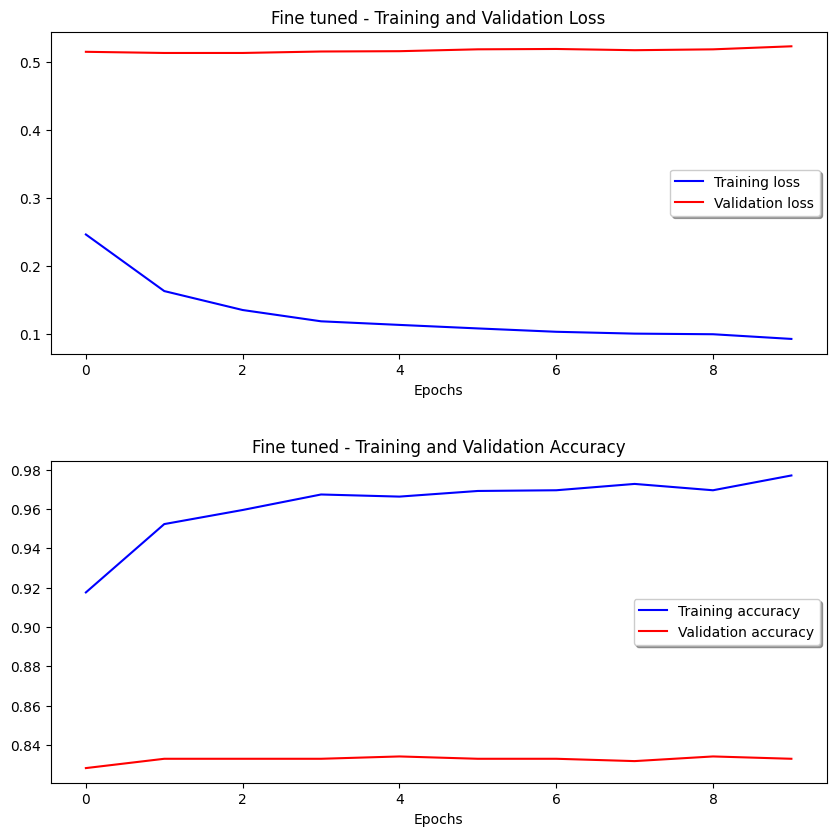

In [17]:
for layer in base_model.layers[:290]:
    layer.trainable = False
for layer in base_model.layers[290:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 10

train_iterator.reset()
validation_iterator.reset()

history = model.fit(
    train_iterator,
    validation_data=validation_iterator,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=[mc_fine_tuned_callback, tb_callback, csv_logger_callback]
)

fig, ax = plt.subplots(2, 1, figsize=(9, 9))

ax[0].set_title('Fine tuned - Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

ax[1].set_title('Fine tuned - Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

plt.tight_layout(pad=3)

figures_path = os.path.join(base_path, 'figures', 'fine_tuned_layers-train_val_loss.jpg')
os.makedirs(os.path.dirname(figures_path), exist_ok=True)
plt.savefig(figures_path, dpi=300)

### **Evaluating the Fine-Tuned Model on the Test Set**
In this section, the model's performance is evaluated on the test set after fine-tuning.

#### **Resetting the Test Iterator**
- `test_iterator.reset()`:  
  - Resets the test data iterator. This is important to ensure that the data is processed from the beginning, especially after training, as iterators can get exhausted.

#### **Evaluating the Model**
- `score = model.evaluate(...)`:  
  - Evaluates the model on the test data:
    - `test_iterator`: The test data iterator, which feeds the model with test images and labels.
    - `batch_size=BATCH_SIZE`: The number of samples processed per batch (as specified earlier).
    - `verbose=1`: Displays progress during evaluation.
  - `score` contains the test loss and accuracy.

#### **Displaying Test Results**
- `print('Test loss:', score[0])`:  
  - Prints the test loss, which is the value of the loss function (categorical cross-entropy) on the test set.
  
- `print('Test accuracy:', score[1])`:  
  - Prints the test accuracy, which is the percentage of correct predictions made by the model on the test set.

This section confirms the model's performance after fine-tuning by reporting its accuracy and loss on the test set.


In [18]:
test_iterator.reset()

score = model.evaluate(
    test_iterator,
    batch_size=BATCH_SIZE,
    verbose=1
)

print('Test loss:', score[0])
print('Test accuracy:', score[1])



27/27 [==============================] - 32s 1s/step - loss: 0.4884 - accuracy: 0.8507
Test loss: 0.48837539553642273
Test accuracy: 0.850710928440094
